In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [ ]:
def incorporate_bc_info(unmappedR1, mappedR2, counts, outputFile):
    unmapped_df = dd.read_csv(unmappedR1, dtype='str', header=None, sep=" ")
    unmapped_df.columns = ['Transcript ID', 'Cell Barcode', 'UMI']
    mapped_df = dd.read_csv(mappedR2, dtype='str', header=None, sep=" ")
    mapped_df.columns = ["Transcript ID", "Barcode"]
    merged_df = dd.merge(mapped_df, unmapped_df, how='inner', on = 'Transcript ID')
    merged_df_first = merged_df.drop_duplicates(subset='Cell Barcode', keep='first')
    merged_df_pandas = merged_df_first.compute()
    sc_data = pd.read_csv(counts)
    sc_data = sc_data.T
    sc_data.reset_index(inplace=True)
    sc_data.columns = sc_data.iloc[0].tolist()
    sc_data.drop(0, axis=0, inplace=True)
    cell_barcode_reads = sc_data['Unnamed: 0']
    cell_barcode_reads_trimmed = [cb.replace('-1', '') for cb in cell_barcode_reads]
    sc_data['Cell Barcode'] = cell_barcode_reads_trimmed
    sc_data.drop('Unnamed: 0', axis=1, inplace=True)
    sc_lineage_data = pd.merge(merged_df_pandas, sc_data, how = "right", on = "Cell Barcode")
    sc_lineage_data.to_csv(outputFile)
    return sc_lineage_data

In [2]:
sc_lineage_data = incorporate_bc_info(unmappedR1 = 'SKMEL5_undiversified_untreated_unmapped_R1_threecol.csv',
                                      mappedR2 = 'output_SKMEL5_undiversified_untreated_mapped_sequences_match.csv',
                                      counts = 'SKMEL5_untreated_undiversified_scRNAseq.csv',
                                      outputFile = 'SKMEL5-undiversified-untreated_scRNAseq-Lineage-Transcript-Cell-UMI.csv')
#sc_lineage_data = pd.read_csv('SKMEL5-undiversified-untreated_scRNAseq-Lineage-Transcript-Cell-UMI.csv')'output_SKMEL5_undiversified_untreated_mapped_sequences_match.csv'

/Users/Corey/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sc_lineage_data.shape

(2886, 25375)

In [6]:
sc_lineage_data_dropna = sc_lineage_data.dropna(subset=['Barcode'])
sc_lineage_data_dropna.shape

(2865, 25375)

In [8]:
# Remove rows where the lineage barcode is not between 17 and 23 nt long (supposed to be 16nt)
sc_lineage_data_dropna['Barcode'] = sc_lineage_data_dropna['Barcode'].astype('str')
mask = (sc_lineage_data_dropna['Barcode'].str.len() >= 17) & (sc_lineage_data_dropna['Barcode'].str.len() <= 23)
sc_lineage_data_dropna_correctbc = sc_lineage_data_dropna.loc[mask]
sc_lineage_data_dropna_correctbc.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(2860, 25375)

In [10]:
bc_values = sc_lineage_data_dropna_correctbc.ix[:,1:5]
sc_values = sc_lineage_data_dropna_correctbc.ix[:,5:]
bc_values.shape

(2860, 4)

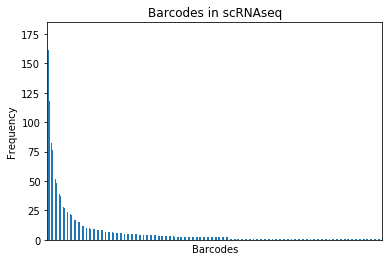

In [69]:
%matplotlib inline
bc_values['Barcode'].value_counts().plot(kind='bar')
axes = plt.gca()
axes.axes.get_xaxis().set_ticks([])
plt.xlabel("Barcodes")
plt.ylabel("Frequency")
plt.title("Barcodes in scRNAseq")
plt.savefig('barcodes_uu_scRNAseq.pdf')

In [71]:
bc_values['Barcode'].value_counts().head()

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
Name: Barcode, dtype: int64

In [75]:
bc_values['Barcode'].value_counts().to_csv('UU_bcCounts.csv')

In [74]:
scRNAseq_barcode_list = bc_values['Barcode'].tolist()
scRNAseq_barcode_list
bc_values['Barcode'].nunique()

423

In [73]:
import Levenshtein
import numpy as np
from sklearn.cluster import DBSCAN

def lev_metric(x,y):
    i,j = int(x[0]), int(y[0])
    return Levenshtein.distance(scRNAseq_barcode_list[i], scRNAseq_barcode_list[j])

X = np.arange(len(scRNAseq_barcode_list)).reshape(-1,1)
db = DBSCAN(metric = lev_metric, eps=2, min_samples=2)
pred = db.fit_predict(X)

df = pd.DataFrame({'barcode': scRNAseq_barcode_list,
                   'cluster_id': pred})
df.sort_values(by=['cluster_id'], ascending = True, inplace = True)
df

,barcode,cluster_id
329,CTGAGTCTCACTGAGTCACA,-1
881,CTGAGTCTGTGTCAGTCTGT,-1
1247,CTGAGTCTGTGACTGAGTCAG,-1
2404,CTGACTCTGTGTCTGACTGT,-1
805,CTGAGACTGTGACAGACTCA,-1
801,CTGACACTCTGAGTCAGA,-1
2445,CTGACTCTCACTGAGACTGT,-1
206,CTGAGTCTGAGACTCTGTCT,-1
882,CTGACAGTGACTCACACAGT,-1
1268,CTGACAGAGTGAGACACTGT,-1


In [21]:
## Data Cleaning - using suggested thresholds from ScanPy ##
# Filter out cells with less than 200 genes
nonzeroes_in_cols = sc_lineage_data_dropna_correctbc.astype(bool).sum(axis=1)
# nonzeroes_in_cols
sum(i > 200 for i in nonzeroes_in_cols)
cell_norm_ind = nonzeroes_in_cols.index[nonzeroes_in_cols > 200].tolist()
sc_cellnorm = sc_lineage_data_dropna_correctbc.ix[cell_norm_ind]
sc_cellnorm = sc_cellnorm.ix[:,1:]
sc_cellnorm.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


(2860, 25374)

In [22]:
# Filter out genes with less than 3 cells
nonzeroes_in_rows = sc_cellnorm.astype(bool).sum(axis=0)
# nonzeroes_in_rows.head(100)
sum(i > 3 for i in nonzeroes_in_rows)
gene_norm_ind = nonzeroes_in_rows.index[nonzeroes_in_rows > 3].tolist()
# gene_norm_ind
sc_cellgenenorm = sc_cellnorm[gene_norm_ind]
sc_cellgenenorm.shape

(2860, 15079)

In [24]:
sc_cellgenenorm.head()

,Transcript ID,Barcode,Cell Barcode,UMI,WASH7P,LOC729737,LOC100288069,FAM87B,LINC00115,LINC01128,...,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,SPRY3,VAMP7
0,A00252:38:HF2JNDMXX:2:1101:7337:1329,CTGACTGTCAGACAGAGTGA,TTAACTCAGCTATGCT,TCCTATCCTT,0,0,0,0,0,1,...,6,2,0,0,2,0,0,1,0,0
1,A00252:38:HF2JNDMXX:2:1101:29116:1438,CTGACAGTGTCACACAGTGA,CGACTTCAGCCAGAAC,TTCCGTCGAA,0,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
2,A00252:38:HF2JNDMXX:2:1101:17707:1470,CTGAGTCAGTCACACTCTGT,GTGTGCGGTCCTAGCG,ATTCGTTGAA,0,0,0,0,0,0,...,5,0,0,0,2,0,0,1,0,0
3,A00252:38:HF2JNDMXX:2:1101:21404:2143,CTGACAGTCAGTCAGTGTGA,CGTGTAATCGGTTAAC,TACACTCTAC,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A00252:38:HF2JNDMXX:2:1101:7545:2503,CTGAGAGACTCTGTGACTGA,CATTCGCAGGGAACGG,TACCTGCTTG,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


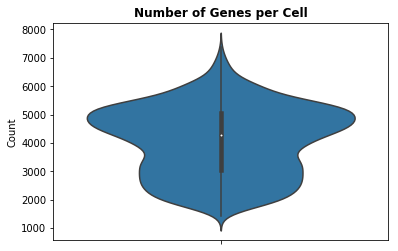

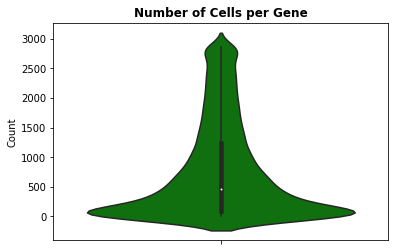

In [25]:
import seaborn as sns
%matplotlib inline

num_genes_percell = sc_cellgenenorm.astype(bool).sum(axis=1)
num_cells_pergene = sc_cellgenenorm.astype(bool).sum(axis=0)
num_cells_pergene_rmbarcodes = num_cells_pergene[4:]

plt.figure()
sns.violinplot(num_genes_percell, orient = "v")
# plt.xlabel("")
plt.ylabel("Count")
plt.title("Number of Genes per Cell", weight = "bold")
plt.savefig("QC_metrics_ngenes_UU.pdf")

plt.figure()
sns.violinplot(num_cells_pergene_rmbarcodes, orient= "v", color="green")
plt.ylabel("Count")
plt.title("Number of Cells per Gene", weight = "bold")
# fig,axes = plt.subplots()
# axes.violinplot(dataset = num_genes_percell)
plt.savefig("QC_metrics_ncells_UU.pdf")

In [26]:
## Data normalization - see powerpoint for detailed explanation ##
import numpy as np
from numpy import inf

totGE_percell = sc_cellgenenorm.ix[:,4:].sum(axis = 1)
totGE_percell_norm = sc_cellgenenorm.ix[:,4:].div(totGE_percell, axis=0)
totGE_percell_norm_scaled = totGE_percell_norm * 100000 #len(totGE_percell_norm.index)
totGE_percell_norm_scaled_log = np.log(totGE_percell_norm_scaled)
totGE_percell_norm_scaled_log_noInf = totGE_percell_norm_scaled_log.replace([np.inf, -np.inf], 0)
totGE_percell_norm_scaled_log_noInf.shape

/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/Corey/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


(2860, 15075)

In [27]:
totGE_percell_norm_scaled_log_noInf.head()

,WASH7P,LOC729737,LOC100288069,FAM87B,LINC00115,LINC01128,FAM41C,SAMD11,NOC2L,KLHL17,...,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,SPRY3,VAMP7
0,0.0,0.0,0.0,0.0,0.0,0.842065,0.0,0.0,0.842065,0.0,...,2.633824,1.535212,0.0,0.0,1.535212,0.0,0.0,0.842065,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.836935,0.0,...,2.143788,0.000000,0.0,0.0,2.836935,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.312802,0.0,...,2.229093,0.000000,0.0,0.0,1.312802,0.0,0.0,0.619655,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.631377,0.0,...,0.000000,1.631377,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [28]:
# Put the dataframe back together with normalized data
sc_data_UU_norm = pd.concat([sc_cellgenenorm.ix[:,:4], totGE_percell_norm_scaled_log_noInf], axis = 1)
sc_data_UU_norm.shape

(2860, 15079)

In [29]:
sc_data_UU_norm.head()

,Transcript ID,Barcode,Cell Barcode,UMI,WASH7P,LOC729737,LOC100288069,FAM87B,LINC00115,LINC01128,...,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,SPRY3,VAMP7
0,A00252:38:HF2JNDMXX:2:1101:7337:1329,CTGACTGTCAGACAGAGTGA,TTAACTCAGCTATGCT,TCCTATCCTT,0.0,0.0,0.0,0.0,0.0,0.842065,...,2.633824,1.535212,0.0,0.0,1.535212,0.0,0.0,0.842065,0.0,0.0
1,A00252:38:HF2JNDMXX:2:1101:29116:1438,CTGACAGTGTCACACAGTGA,CGACTTCAGCCAGAAC,TTCCGTCGAA,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.143788,0.000000,0.0,0.0,2.836935,0.0,0.0,0.000000,0.0,0.0
2,A00252:38:HF2JNDMXX:2:1101:17707:1470,CTGAGTCAGTCACACTCTGT,GTGTGCGGTCCTAGCG,ATTCGTTGAA,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.229093,0.000000,0.0,0.0,1.312802,0.0,0.0,0.619655,0.0,0.0
3,A00252:38:HF2JNDMXX:2:1101:21404:2143,CTGACAGTCAGTCAGTGTGA,CGTGTAATCGGTTAAC,TACACTCTAC,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,A00252:38:HF2JNDMXX:2:1101:7545:2503,CTGAGAGACTCTGTGACTGA,CATTCGCAGGGAACGG,TACCTGCTTG,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,1.631377,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


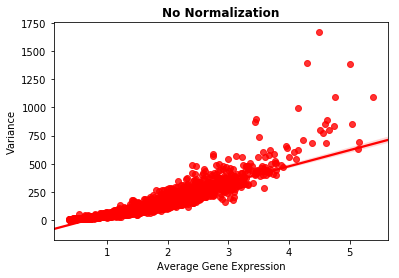

In [30]:
geneMeans_noNorm = sc_cellgenenorm.mean(axis = 1)
geneVars_noNorm = sc_cellgenenorm.var(axis = 1)

sns.regplot(x=geneMeans_noNorm,y=geneVars_noNorm, color = "red")
plt.xlabel("Average Gene Expression")
plt.ylabel("Variance")
plt.title("No Normalization", weight = "bold")
plt.savefig("AvgGE_Var_noNorm_UU.pdf")

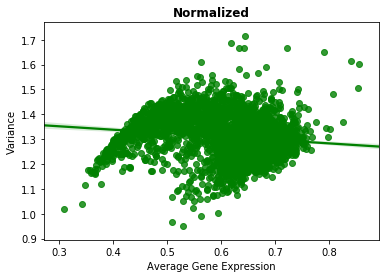

In [31]:
geneMeans_norm = totGE_percell_norm_scaled_log_noInf.mean(axis = 1)
geneVars_norm = totGE_percell_norm_scaled_log_noInf.var(axis = 1)

sns.regplot(x=geneMeans_norm,y=geneVars_norm, color = "green")
plt.xlabel("Average Gene Expression")
plt.ylabel("Variance")
plt.title("Normalized", weight = "bold")
plt.savefig("AvgGE_Var_Norm_UU.pdf")

In [32]:
# Indexing barcodes so that you can color them on plot
norm_bc_names = sc_data_UU_norm['Barcode']
norm_bc_names_indexed = norm_bc_names.astype('category')
norm_bc_names_numindexed = norm_bc_names_indexed.cat.codes
norm_bc_names_indexed.value_counts().head()

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
Name: Barcode, dtype: int64

In [34]:
from sklearn.decomposition import PCA
# Principal Component Analysis (PCA) of whole normalized dataset
norm_pca = PCA(n_components=2)
norm_sc_values_r = norm_pca.fit(sc_data_UU_norm.iloc[:,4:])
norm_sc_values_r_transform = norm_pca.fit(sc_data_UU_norm.iloc[:,4:]).transform(sc_data_UU_norm.iloc[:,4:])

In [35]:
# Getting number of colors the length of unique barcodes
from random import randint
colors = []
lw = 2

for i in range(len(norm_bc_names.unique())):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
colors

['#FBFA12',
 '#C0150E',
 '#38AB09',
 '#89C67D',
 '#425D22',
 '#A72BEA',
 '#F699AD',
 '#E94BB6',
 '#693741',
 '#57ED8F',
 '#30E598',
 '#7EF740',
 '#E378F8',
 '#2DC160',
 '#9BB016',
 '#5D976F',
 '#79FBCB',
 '#500B63',
 '#620FE4',
 '#91AFF3',
 '#4DE601',
 '#0088B3',
 '#B22FF0',
 '#4230C8',
 '#CA753B',
 '#75A4A2',
 '#53D188',
 '#0F5573',
 '#4FED92',
 '#85C7BA',
 '#78D6C5',
 '#B9350A',
 '#2E5323',
 '#B9E021',
 '#56C622',
 '#681439',
 '#BFABB7',
 '#105A8F',
 '#8DD290',
 '#16F21D',
 '#BA002D',
 '#B2007E',
 '#D1B34C',
 '#D7EC3D',
 '#F936AE',
 '#27CC2E',
 '#016207',
 '#E3AD0A',
 '#E86A44',
 '#C8A19A',
 '#7660E6',
 '#B62200',
 '#4A8F39',
 '#DD9B7D',
 '#AE3AA1',
 '#99863D',
 '#72CB04',
 '#C34263',
 '#B22C12',
 '#A75B9B',
 '#100FB9',
 '#CF6CF8',
 '#0C4F07',
 '#4F0AAA',
 '#48E7AC',
 '#72C345',
 '#3FB3A1',
 '#498C2D',
 '#6C1E60',
 '#CAB927',
 '#FC7B0C',
 '#265A48',
 '#4C2EAB',
 '#CCED65',
 '#BA6727',
 '#7F186A',
 '#55A152',
 '#CDE01C',
 '#6DA258',
 '#BFF593',
 '#B81244',
 '#262609',
 '#426B45',
 '#1

explained variance ratio (first two components): [ 0.04537392  0.02295029]


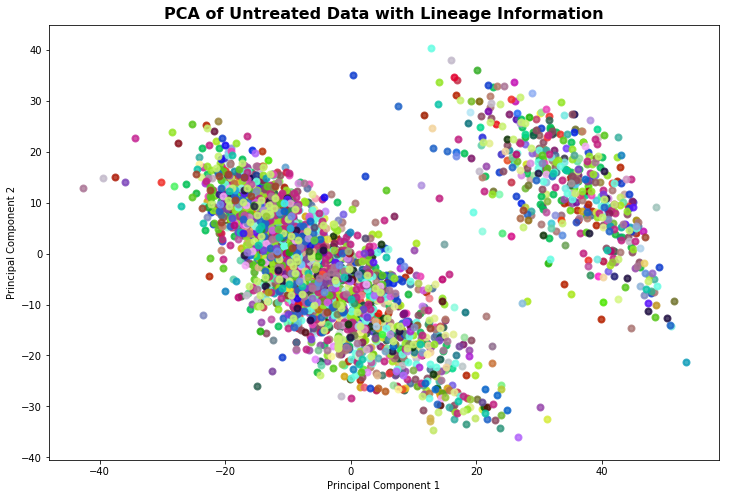

In [36]:
# Plot normalized data PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca.explained_variance_ratio_))

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

for color, i, bc_name in zip(colors, range(len(norm_bc_names.unique())), norm_bc_names.unique()):
    plt.scatter(norm_sc_values_r_transform[norm_bc_names_numindexed==i,0], 
                norm_sc_values_r_transform[norm_bc_names_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode (Top 10)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA of Untreated Data with Lineage Information', fontsize = 16, weight = "bold")
plt.savefig('PCA_untreated_lineage_norm_UU.pdf')

In [37]:
from sklearn.decomposition import PCA
# Principal Component Analysis (PCA) of whole normalized dataset
norm_pca_3d = PCA(n_components=3)
norm_sc_values_r_3d = norm_pca.fit(sc_data_UU_norm.iloc[:,4:])
norm_sc_values_r_transform_3d = norm_pca_3d.fit(sc_data_UU_norm.iloc[:,4:]).transform(sc_data_UU_norm.iloc[:,4:])

In [39]:
norm_sc_values_r_transform_3d

array([[-21.92054738,   5.80972281,  -4.76593402],
       [ 22.68649087,  32.78167109,   9.64730181],
       [-21.36462594,  16.23184331,  -3.46804522],
       ..., 
       [-14.70017726,   8.79599134,  -5.64918906],
       [ 34.64540609,  10.19663167,  20.76169896],
       [ -3.54518169,  -4.22308707,  -4.47363296]])

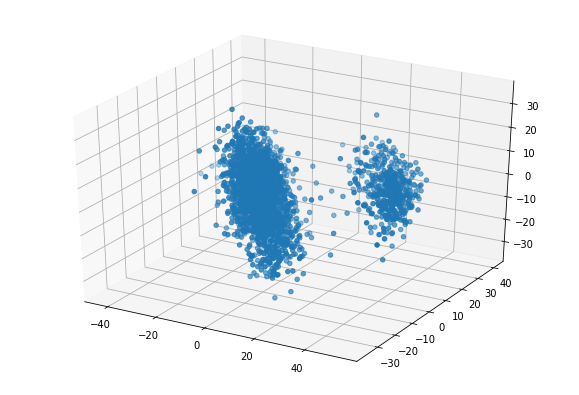

In [40]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(data):#, colors):    
  w, y, z = data.T
  fig = plt.figure(figsize=(10, 5.5/8*10))  
  ax1 = fig.add_subplot(111, projection='3d')
  ax1.scatter(w, y, z)#, color=colors)
plot_3d(norm_sc_values_r_transform_3d)

In [41]:
# Principal Component Analysis (10 components, to be followed by t-SNE) of normalized data
norm_pca_10comp = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_10comp = norm_pca_10comp.fit(sc_data_UU_norm.iloc[:,4:])
norm_sc_values_r_transform_10comp = norm_pca_10comp.fit(sc_data_UU_norm.iloc[:,4:]).transform(sc_data_UU_norm.iloc[:,4:])

In [42]:
norm_sc_values_r_transform_10comp

array([[-21.92054738,   5.80972283,  -4.76593512, ...,   4.32905266,
         -1.4613369 ,   1.39505931],
       [ 22.68649087,  32.78167109,   9.64730146, ..., -10.50821197,
          5.74806889,   6.7893057 ],
       [-21.36462594,  16.2318433 ,  -3.46804414, ...,   8.09960659,
          4.52280021,   0.75178104],
       ..., 
       [-14.70017726,   8.79599134,  -5.64918927, ...,  -6.32024359,
         -6.17492294,  -9.96633686],
       [ 34.64540609,  10.19663168,  20.76169826, ...,  -6.29930561,
          5.99043223,  -9.90499695],
       [ -3.54518169,  -4.22308703,  -4.47363525, ...,   5.95840428,
         -3.12294522,   5.04437665]])

In [43]:
# t-SNE on 10 component PCA of normalized data
from MulticoreTSNE import MulticoreTSNE as TSNE
import time as time

tsne_norm_10comp_diffperp_results = []
perplexities = [5,10,15,20,25,30,35,40,45,50]
for perp in perplexities:
    time_start = time.time()
    tsne_norm_10comp_diffperp = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_10comp_diffperp_results.append(tsne_norm_10comp_diffperp.fit_transform(norm_sc_values_r_transform_10comp))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


t-SNE done! Time elapsed: 15.9153039455 seconds

t-SNE done! Time elapsed: 15.0656220913 seconds

t-SNE done! Time elapsed: 15.8738770485 seconds

t-SNE done! Time elapsed: 17.195980072 seconds

t-SNE done! Time elapsed: 18.4156630039 seconds

t-SNE done! Time elapsed: 18.3045899868 seconds

t-SNE done! Time elapsed: 18.7351329327 seconds

t-SNE done! Time elapsed: 21.2090260983 seconds

t-SNE done! Time elapsed: 18.2649741173 seconds

t-SNE done! Time elapsed: 19.9617879391 seconds


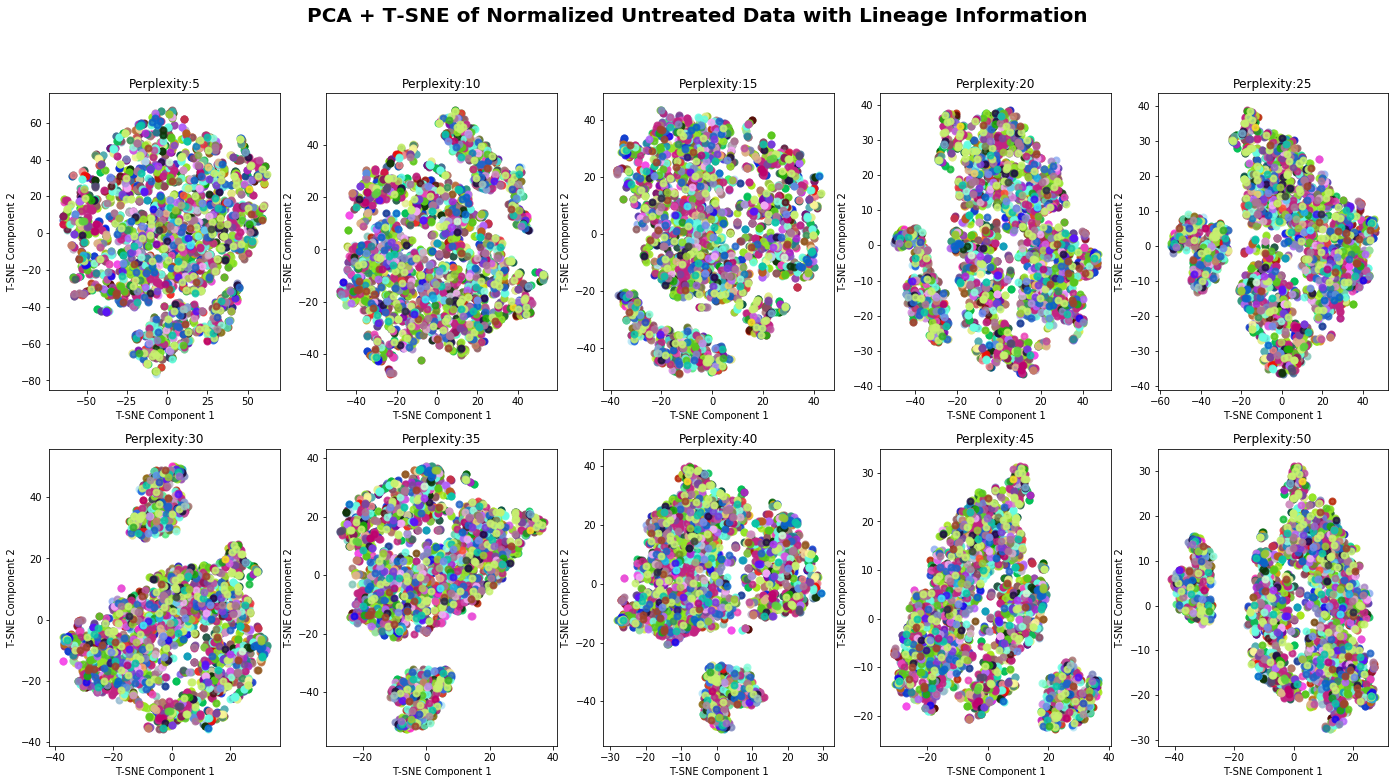

In [44]:
# Plotting normalized data PCA + t-SNE with lineage information. Different boxes have different 
# t-SNE perplexities - see powerpoint for detailed discussion of why that matters

%matplotlib inline

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA + T-SNE of Normalized Untreated Data with Lineage Information", fontsize = 20, weight = "bold")
for p in range(len(tsne_norm_10comp_diffperp_results)):
    ax = fig.add_subplot(2,5,p+1)
    ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    for color, i, bc_name in zip(colors, range(len(norm_bc_names.unique())), norm_bc_names.unique()):
        plt.scatter(tsne_norm_10comp_diffperp_results[p][norm_bc_names_numindexed==i,0], 
                    tsne_norm_10comp_diffperp_results[p][norm_bc_names_numindexed==i,1], 
                    color=color, alpha=0.8, lw=2, 
                    label = bc_name)
plt.savefig("TSNE+PCA_diffperp_UU.pdf")

In [45]:
# Take top10 highest prevalence lineage barcodes
subset_highLB = norm_bc_names_indexed.value_counts().head(10).index.tolist()
subset_highLB

['CTGAGTCAGAGTGACACACT',
 'CTGAGAGTGAGTCTGTCAGT',
 'CTGAGTCACTCACTGAGTGT',
 'CTGAGTGTGAGAGTGTGTGT',
 'CTGACAGTGTCACACAGTGA',
 'CTGAGAGACTCTGTGACTGA',
 'CTGAGACTCAGACAGACACT',
 'CTGACTGTCAGACAGAGTGA',
 'CTGAGTCAGTCACACTCTGT',
 'CTGACTGTCTGTCAGTGTGT']

In [47]:
# Subset data by the above lineage barcodes
sc_data_UU_norm_top10LB = sc_data_UU_norm[sc_data_UU_norm['Barcode'].isin(subset_highLB)]
sc_data_UU_norm_top10LB.shape

(989, 15079)

In [53]:
sc_data_UU_norm_top10LB.head()

,Transcript ID,Barcode,Cell Barcode,UMI,WASH7P,LOC729737,LOC100288069,FAM87B,LINC00115,LINC01128,...,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE,SPRY3,VAMP7
0,A00252:38:HF2JNDMXX:2:1101:7337:1329,CTGACTGTCAGACAGAGTGA,TTAACTCAGCTATGCT,TCCTATCCTT,0.0,0.0,0.0,0.0,0.0,0.842065,...,2.633824,1.535212,0.0,0.0,1.535212,0.0,0.0,0.842065,0.0,0.0
1,A00252:38:HF2JNDMXX:2:1101:29116:1438,CTGACAGTGTCACACAGTGA,CGACTTCAGCCAGAAC,TTCCGTCGAA,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.143788,0.000000,0.0,0.0,2.836935,0.0,0.0,0.000000,0.0,0.0
2,A00252:38:HF2JNDMXX:2:1101:17707:1470,CTGAGTCAGTCACACTCTGT,GTGTGCGGTCCTAGCG,ATTCGTTGAA,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.229093,0.000000,0.0,0.0,1.312802,0.0,0.0,0.619655,0.0,0.0
4,A00252:38:HF2JNDMXX:2:1101:7545:2503,CTGAGAGACTCTGTGACTGA,CATTCGCAGGGAACGG,TACCTGCTTG,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,1.631377,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
6,A00252:38:HF2JNDMXX:2:1101:3775:3458,CTGAGTGTGAGAGTGTGTGT,CTACACCAGTCGATAA,GTCATCAGTA,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,2.445878,0.0,0.0,0.000000,0.0,0.0


In [50]:
sc_data_UU_norm_top10LB['Barcode'].unique()

array(['CTGACTGTCAGACAGAGTGA', 'CTGACAGTGTCACACAGTGA',
       'CTGAGTCAGTCACACTCTGT', 'CTGAGAGACTCTGTGACTGA',
       'CTGAGTGTGAGAGTGTGTGT', 'CTGAGACTCAGACAGACACT',
       'CTGAGAGTGAGTCTGTCAGT', 'CTGAGTCAGAGTGACACACT',
       'CTGAGTCACTCACTGAGTGT', 'CTGACTGTCTGTCAGTGTGT'], dtype=object)

In [52]:
# Getting number of colors the length of unique barcodes
from random import randint
colors1 = []
lw = 2

for i in range(len(sc_data_UU_norm_top10LB['Barcode'].unique())):
    colors1.append('#%06X' % randint(0, 0xFFFFFF))
    
colors1

['#6FC656',
 '#12FD74',
 '#723F61',
 '#A3B1D8',
 '#C61871',
 '#91E1E4',
 '#9CEB2A',
 '#E0D016',
 '#0C3745',
 '#4BCD2D']

In [54]:
# Principal Component Analysis with T-SNE
norm_pca_top10_10comp = PCA(n_components=10) # Copying 10x and ScanPy 
norm_sc_values_r_top10_10comp = norm_pca_top10_10comp.fit(sc_data_UU_norm_top10LB.iloc[:,4:])
norm_sc_values_r_transform_top10_10comp = norm_pca_top10_10comp.fit(sc_data_UU_norm_top10LB.iloc[:,4:]).transform(sc_data_UU_norm_top10LB.iloc[:,4:])



In [55]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import time as time

tsne_norm_top10_10comp_diffperp_results = []
perplexities = [5,10,15,20,25,30,35,40,45,50]
for perp in perplexities:
    time_start = time.time()
    tsne_norm_top10_10comp_diffperp = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=1000, n_jobs=8)
    tsne_norm_top10_10comp_diffperp_results.append(tsne_norm_top10_10comp_diffperp.fit_transform(norm_sc_values_r_transform_top10_10comp))
    print
    print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


t-SNE done! Time elapsed: 5.97485899925 seconds

t-SNE done! Time elapsed: 5.73020005226 seconds

t-SNE done! Time elapsed: 5.77889585495 seconds

t-SNE done! Time elapsed: 5.82695889473 seconds

t-SNE done! Time elapsed: 6.03096985817 seconds

t-SNE done! Time elapsed: 5.95100188255 seconds

t-SNE done! Time elapsed: 6.31714105606 seconds

t-SNE done! Time elapsed: 6.5267829895 seconds

t-SNE done! Time elapsed: 6.6406390667 seconds

t-SNE done! Time elapsed: 6.83682703972 seconds


In [57]:
# Indexing barcodes so that you can color them on plot
norm_bc_names_top10 = sc_data_UU_norm_top10LB['Barcode']
norm_bc_names_top10_indexed = norm_bc_names_top10.astype('category')
norm_bc_names_top10_numindexed = norm_bc_names_top10_indexed.cat.codes
norm_bc_names_top10_indexed.value_counts()

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
CTGAGAGACTCTGTGACTGA     82
CTGAGACTCAGACAGACACT     76
CTGACTGTCAGACAGAGTGA     64
CTGAGTCAGTCACACTCTGT     61
CTGACTGTCTGTCAGTGTGT     53
Name: Barcode, dtype: int64

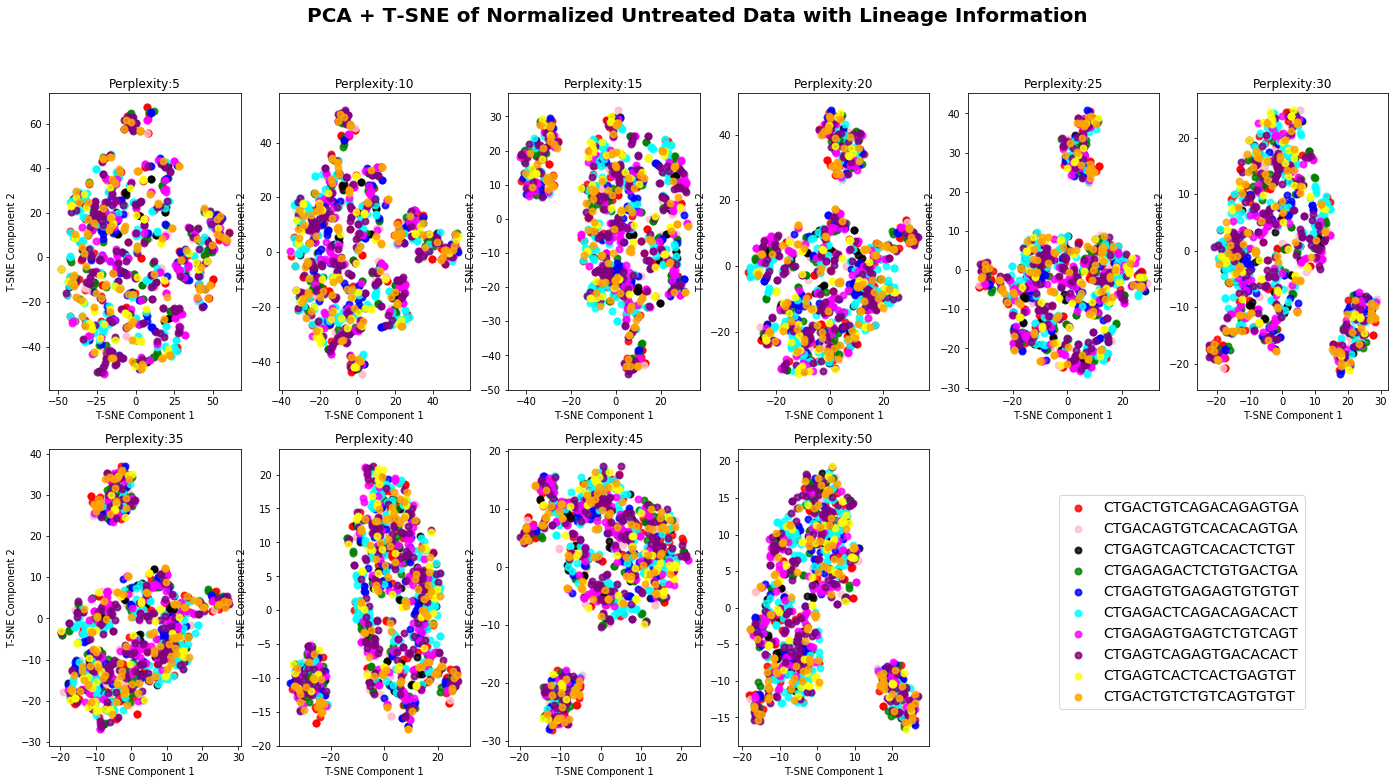

In [59]:
%matplotlib inline

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA + T-SNE of Normalized Untreated Data with Lineage Information", fontsize = 20, weight = "bold")
for p in range(len(tsne_norm_top10_10comp_diffperp_results)):
    ax = fig.add_subplot(2,6,p+1)
    ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
        plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,0], 
                    tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,1], 
                    color=color, alpha=0.8, lw=2, 
                    label = bc_name)
plt.legend(loc = "lower right", bbox_to_anchor = (1,0.10,2,1), prop={'size':14})
plt.savefig("UU_top10_Norm_PCA+TSNE_diffperp.pdf")

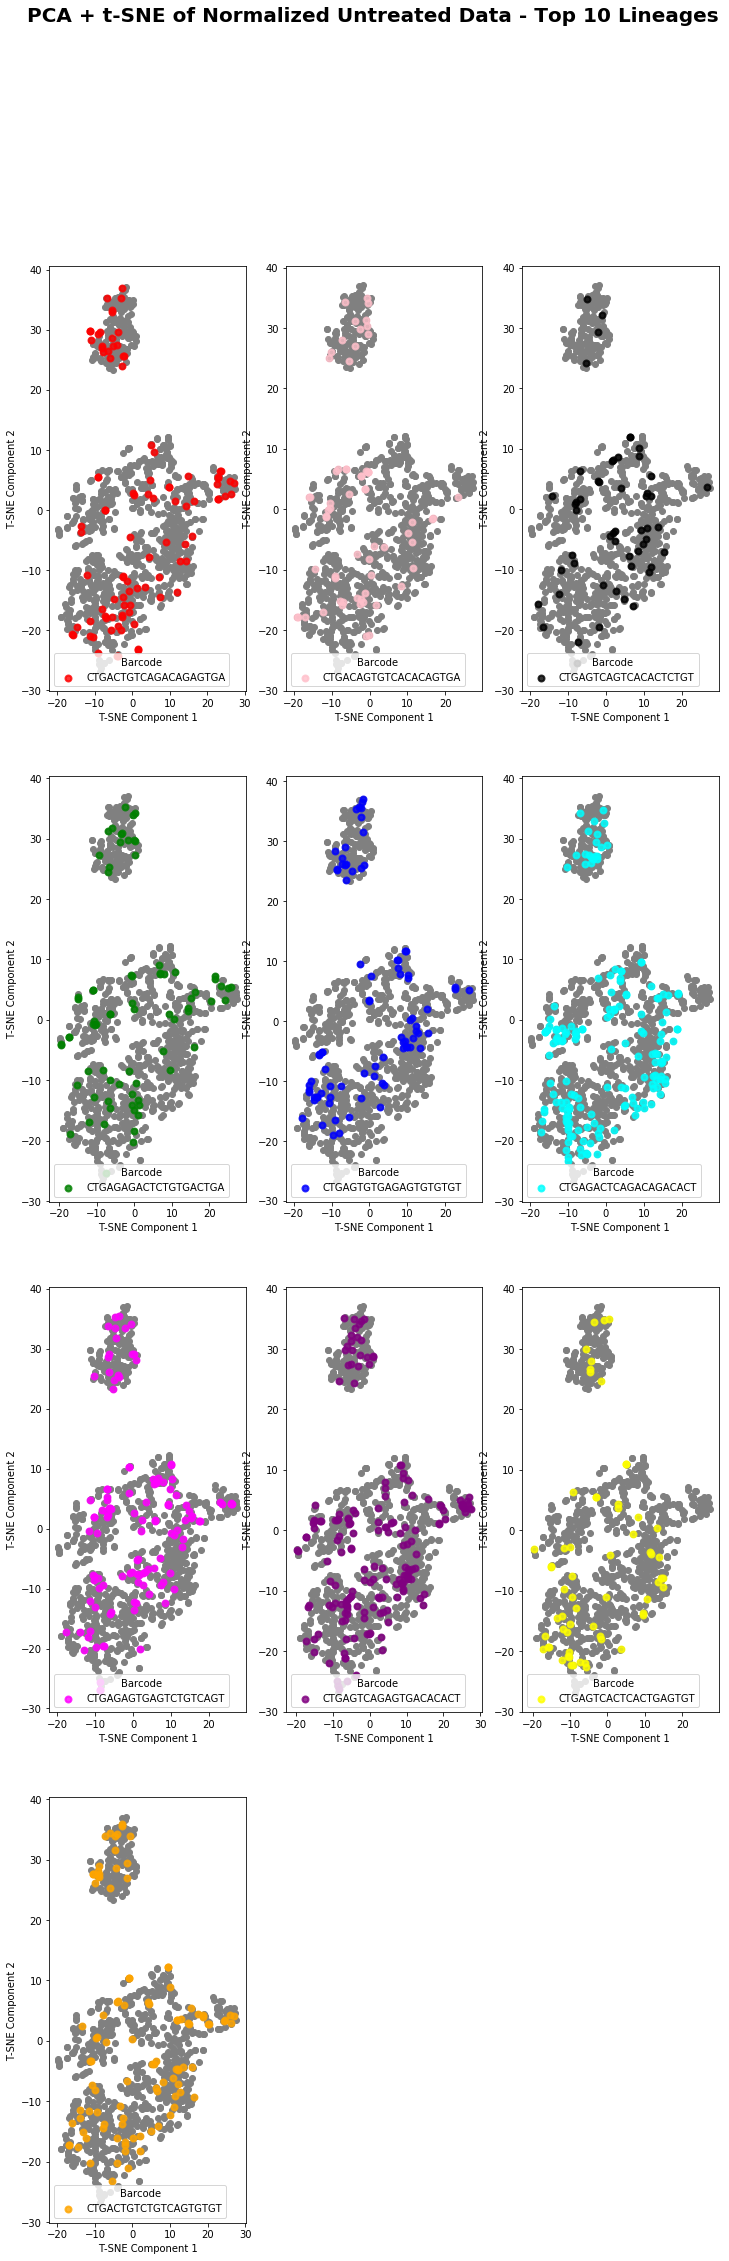

In [67]:
fig = plt.figure(figsize = (12,36))
fig.suptitle("PCA + t-SNE of Normalized Untreated Data - Top 10 Lineages", fontsize = 20, weight = "bold")

p = 6

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    ax = fig.add_subplot(4,3,i+1)
#     ax.set_title("Perplexity:" + str(perplexities[p]))
    ax.set_xlabel("T-SNE Component 1")
    ax.set_ylabel("T-SNE Component 2")
    plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][:,0], tsne_norm_top10_10comp_diffperp_results[p][:,1], color = "grey")
    plt.scatter(tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,0], 
                tsne_norm_top10_10comp_diffperp_results[p][norm_bc_names_top10_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, title = "Barcode")

plt.savefig('UU_PCA+tSNE_perp35_wlineage_Norm_4x3.pdf')

In [61]:
# Principal Component Analysis
norm_pca_top10 = PCA(n_components=2)
norm_sc_values_r_top10 = norm_pca_top10.fit(sc_data_UU_norm_top10LB.iloc[:,4:])
norm_sc_values_r_top10_transform = norm_pca_top10.fit(sc_data_UU_norm_top10LB.iloc[:,4:]).transform(sc_data_UU_norm_top10LB.iloc[:,4:])

explained variance ratio (first two components): [ 0.0470666   0.02286243]


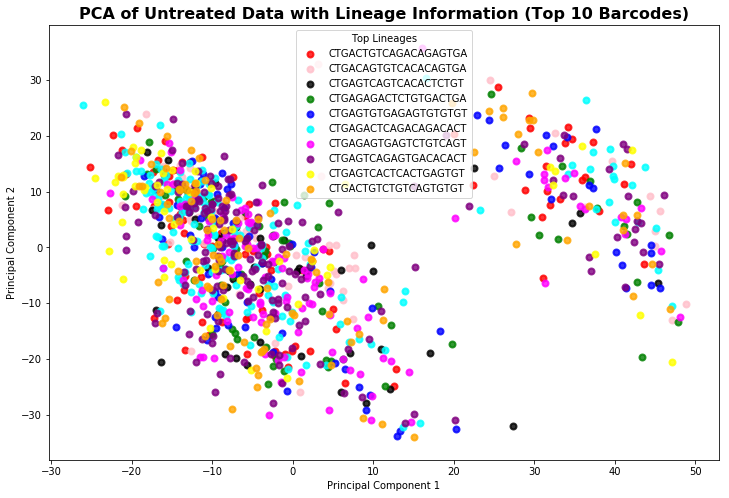

In [63]:
# Plot top10 lineages PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca_top10.explained_variance_ratio_))

dims = (12,8)

fig,ax = plt.subplots(figsize=dims)

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

# print(colors1)
# print(range(len(test_bc_names_top10.unique())))
# print(test_bc_names_top10.unique())
# print(zip(colors1, range(len(test_bc_names_top10.unique())), test_bc_names_top10.unique()))

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    plt.scatter(norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,0], 
                norm_sc_values_r_top10_transform[norm_bc_names_top10_numindexed==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, title="Top Lineages")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA of Untreated Data with Lineage Information (Top 10 Barcodes)', fontsize = 16, weight = "bold")
plt.savefig('UU_PCA_lineage_norm_top10.pdf')

In [ ]:
# Plot top10 lineages PCA with lineage information
% matplotlib inline

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(norm_pca_top10.explained_variance_ratio_))

colors1 = ['red', 'pink', 'black', 'green', 'blue',
          'aqua', 'magenta', 'purple', 'yellow', 'orange']

fig = plt.figure(figsize = (24,12))
fig.suptitle("PCA Normalized Untreated Data with Top10 Lineages", fontsize = 20, weight = "bold")

for color, i, bc_name in zip(colors1, range(len(norm_bc_names_top10.unique())), norm_bc_names_top10.unique()):
    ax = fig.add_subplot(2,5,i+1)
    plt.scatter(norm_sc_values_r_top10_transform[:,0], norm_sc_values_r_top10_transform[:,1], color = "grey")
    plt.scatter(norm_sc_values_r_top10_transform[norm_bc_names_numindexed_top10==i,0], 
                norm_sc_values_r_top10_transform[norm_bc_names_numindexed_top10==i,1], 
                color=color, alpha=0.8, lw=2, 
                label = bc_name)
#     print(bc_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1, title="Barcode")
plt.savefig("PCA_untreated_lineage_norm_5x2.pdf")